In [ ]:
from imutils import contours
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow

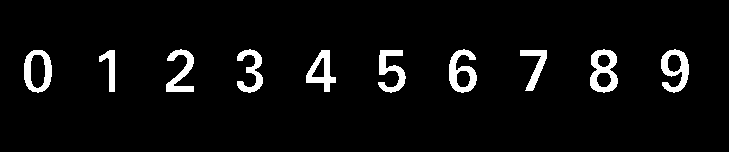

In [ ]:
# load the template
ref = cv2.imread('template.png')
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
cv2_imshow(ref)

In [ ]:
# find contours ot the template and sort them from left to right
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[0]
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

In [ ]:
# initialize a dictionary to map digit name to the ROI
digits = {}

# loop over the template contours
for (i, cnt) in enumerate(refCnts):
	# compute the bounding box for the digit, extract it, and resize it to a fixed size
	(x, y, w, h) = cv2.boundingRect(cnt)
	roi = ref[y : y + h, x : x + w]
	cv2_imshow(roi)
	print()

	roi = cv2.resize(roi, (57, 88))

	# mapping the digit name to the ROI
	digits[i] = roi

In [ ]:
# initialize a rectangular (wider than it is tall) and square structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

In [ ]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread('card.jpg')
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [ ]:
# apply a tophat morphological operator to find light regions against a dark background
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
cv2_imshow(tophat)

In [ ]:
# compute the gradient of the tophat image, then scale the rest back into the range [0, 255]
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
cv2_imshow(gradX)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
cv2_imshow(gradX)

In [ ]:
# apply a closing operation using the rectangular kernel to help fill the gaps inside credit card number digits,
# then apply Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
cv2_imshow(gradX)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

In [ ]:
# apply a second closing operation to the binary image
# thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
# cv2_imshow(thresh)

In [ ]:
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0]

In [ ]:
# initialize the list of digit locations
locs = []

# loop over the contours
for (i, c) in enumerate(cnts):
	# compute the bounding box of the contour, then use the bounding box coordinates to derive the aspect ratio
	x, y, w, h = cv2.boundingRect(c)
	ar = w / float(h)

	# since credit cards used a fixed size fonts with 4 groups of 4 digits,
	# we can filter potential contours based on the aspect ratio
	if ar > 2.5 and ar < 4.0:
		# contours can further be filtered on minimum/maximum width and height
		if (w > 40 and w < 55) and (h > 10 and h < 20):
			locs.append((x, y, w, h))

In [ ]:
# sort the digit locations from left-to-right
locs = sorted(locs, key=lambda x:x[0])

In [ ]:
# initialize the list of classified digits
output = []

# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
  # initialize the list of group digits
  groupOutput = []

  # extract the group ROI of 4 digits from the grayscale image,
  # then apply thresholding to segment the digits from the background of the credit card
  group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
  cv2_imshow(group)
  group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  cv2_imshow(group)

  # detect the contours of each individual digit in the group,
  # then sort the digit contours from left to right
  digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  digitCnts = digitCnts[0]
  digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]

  # loop over the digit contours
  for c in digitCnts:
    # compute the bounding box of the individual digit, extract the digit,
    # and resize it to have the same fixed size as the template images
    (x, y, w, h) = cv2.boundingRect(c)
    roi = group[y:y + h, x:x + w]
    cv2_imshow(roi)
    roi = cv2.resize(roi, (57, 88))

    # initialize a list of template matching scores
    scores = []

    # loop over the reference digit name and digit ROI
    for (digit, digitROI) in digits.items():
      # apply correlation-based template matching, take the score, and update the scores list
      result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
      (_, score, _, _) = cv2.minMaxLoc(result)
      scores.append(score)

    # the classification for the digit ROI will be the reference
    # digit name with the *largest* template matching score
    if max(scores) > 100000:
      groupOutput.append(str(np.argmax(scores)))

  # draw the digit classifications around the group
  cv2.rectangle(image, (gX - 5, gY - 5), (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
  cv2.putText(image, "".join(groupOutput), (gX, gY - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

  # update the output digits list
  output.extend(groupOutput)

In [ ]:
print("Credit Card #: {}".format("".join(output)))
cv2_imshow(image)